In [1]:
import gradio as gr
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from demo.cam import generate_gradcam, GradCAM
from captum.attr import LayerGradCam
from PIL import Image
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch.nn.functional as F
from scipy.ndimage import filters
from torch import nn

c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\models\auto\image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:

model_path = "deepseek-ai/Janus-Pro-1B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True,
                                             ignore_mismatched_sizes=True # Adding CLS token, will be handled manually
                                             )

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16
# dtype = torch.bfloat32 if torch.cuda.is_available() else torch.float32

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(dtype).cuda()
else:
    # vl_gpt = vl_gpt.to(torch.float16)
    torch.set_default_device("mps")
    vl_gpt = vl_gpt.to(dtype)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'mps'

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: image_tag, ignore_id, sft_format, mask_prom

In [17]:
print(config.language_config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 16384,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_heads": 16,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.48.1",
  "use_cache": true,
  "vocab_size": 102400
}



In [3]:
class AttentionGuidedCAM:
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers[-1:]
        self.gradients = []
        self.activations = []
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        """ Registers hooks to extract activations and gradients from ALL attention layers. """
        for layer in self.target_layers:
            self.hooks.append(layer.register_forward_hook(self._forward_hook))
            self.hooks.append(layer.register_backward_hook(self._backward_hook))

    def _forward_hook(self, module, input, output):
        """ Stores attention maps (before softmax) """
        self.activations.append(output)

    def _backward_hook(self, module, grad_in, grad_out):
        """ Stores gradients """
        self.gradients.append(grad_out[0])

    def generate_cam(self, input_tensor, tokenizer, temperature, top_p, class_idx=None):
        """ Generates Grad-CAM heatmap for ViT. """
        self.model.zero_grad()
        
        # Forward pass
        image_embeddings_pooled, inputs_embeddings, outputs = self.model(input_tensor, tokenizer, temperature, top_p)

        print("image_embeddings_shape: ", image_embeddings_pooled.shape)

        input_ids = input_tensor.input_ids
        img_token_positions = input_tensor.images_seq_mask

        # Pooling

        inputs_embeddings_pooled = inputs_embeddings.mean(dim=1) # end of image: 618


        # Backpropagate to get gradients
        image_embeddings_pooled.backward(inputs_embeddings_pooled, retain_graph=True)


        # Aggregate activations and gradients from ALL layers
        cam_sum = None
        for act, grad in zip(self.activations, self.gradients):
            # act = torch.sigmoid(act)
            act = F.relu(act[0])
 

            # Compute mean of gradients
            grad_weights = grad.mean(dim=-1, keepdim=True)

            print("act shape", act.shape)
            print("grad_weights shape", grad_weights.shape)

            cam, _ = (act * grad_weights).max(dim=-1)
            print(cam.shape)

            # Sum across all layers
            if cam_sum is None:
                cam_sum = cam
            else:
                cam_sum += cam  



        # Create attention
        attn_stack = torch.stack(outputs.attentions)  # (24, 1, 16, <sequence_length>, <sequence_length>) -> (block, batch, head, shape, shape)
        attn_avg = attn_stack.mean(dim=2)  # Average across heads (24, 1, <sequence_length>, <sequence_length>)

        print("attn_avg_shape:", attn_avg.shape)
        print("img_token_shape:", img_token_positions.shape)
        
        img_attention_scores = attn_avg[:, :, :, img_token_positions[0]]  # Extract attention to image tokens, (24, 1, <sequence_length>, 576)
        # img_attention_weights = img_attention_scores.mean(dim=0)
        img_attention_weights = img_attention_scores[-1] # select last block's attentions

        print("img_attention_weights_shape:", img_attention_weights.shape)

        # use attn map as cam_sum
        cam_sum = img_attention_weights[:, class_idx, :]
        # cam_sum = img_attention_weights[:, class_idx, :] * cam_sum[0, 1:]

        # Normalize
        cam_sum = F.relu(cam_sum)
        cam_sum = cam_sum - cam_sum.min()
        cam_sum = cam_sum / cam_sum.max()

        # thresholding
        cam_sum = cam_sum.to(torch.float32)
        percentile = torch.quantile(cam_sum, 0.2)  # Adjust threshold dynamically
        cam_sum[cam_sum < percentile] = 0

        # Reshape
        # cam_sum = cam_sum[0, 1:]
        print("cam_sum shape: ", cam_sum.shape)
        num_patches = cam_sum.shape[-1]  # Last dimension of CAM output
        grid_size = int(num_patches ** 0.5)
        print(f"Detected grid size: {grid_size}x{grid_size}")

        # Fix the reshaping step dynamically


        
        
        
        cam_sum = cam_sum.view(grid_size, grid_size)


        return cam_sum, grid_size, outputs

    def remove_hooks(self):
        """ Remove hooks after usage. """
        for hook in self.hooks:
            hook.remove()

In [4]:
def multimodal_understanding(image, question, seed, top_p, temperature, target):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()


    for param in vl_gpt.parameters():
        param.requires_grad = True
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    

    # Get the last transformer block of the Vision Transformer (ViT)


    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = [Image.fromarray(image)]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=dtype)

    # print(prepare_inputs)

    print("generating guided gradcam...")
    

    # Compute the attributions.
    target_layers = [block.norm1 for block in vl_gpt.vision_model.vision_tower.blocks]

    gradcam = AttentionGuidedCAM(vl_gpt, target_layers)
    cam_tensor, grid_size, outputs  = gradcam.generate_cam(prepare_inputs, tokenizer, temperature, top_p, target)

    input_ids = prepare_inputs.input_ids[0].cpu().tolist()
    input_ids_decoded = [tokenizer.decode([input_ids[i]]) for i in range(len(input_ids))]
    
    
    return cam_tensor, input_ids_decoded, outputs

In [5]:
# IMG_PATH = "../images/doge.png"
# question = "Find the Visual Encoding text."

IMG_PATH = "../images/AreaChart.png"
question = "What is the coffee price in April 2019?"

# IMG_PATH = "../images/PieChart.png"
# question = "Other"

# IMG_PATH = "../images/pie_chart.png"
# question = ""

IMG_PATH = "../images/cat_dog.png"
question = "cat"


# question = "Text including coffee"

image = Image.open(IMG_PATH)
image_arr = np.array(image)
target_token_idx = -5

cam_tensor, input_ids_decoded, outputs = multimodal_understanding(image_arr, question, 100, 0.95, 0, target=target_token_idx)


generating guided gradcam...


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Select Feature Methodology:  same
image_embeds shape:  torch.Size([1, 576, 2048])
inputs_embeds shape:  torch.Size([1, 625, 2048])
image_embeddings_shape:  torch.Size([1, 2048])
act shape torch.Size([576, 1024])
grad_weights shape torch.Size([1, 576, 1])
torch.Size([1, 576])
attn_avg_shape: torch.Size([24, 1, 625, 625])
img_token_shape: torch.Size([1, 625])
img_attention_weights_shape: torch.Size([1, 625, 576])
cam_sum shape:  torch.Size([1, 576])
Detected grid size: 24x24


In [12]:
print(len(input_ids_decoded))

625


In [15]:
print(outputs.logits)

tensor([[[22.6250, 24.2500, 22.6250,  ..., 14.0000, 14.0625, 14.0000],
         [65.5000, 62.7500, 60.5000,  ..., 52.5000, 52.5000, 52.5000],
         [60.5000, 57.2500, 52.0000,  ..., 50.7500, 50.7500, 51.0000],
         ...,
         [51.2500, 58.5000, 48.0000,  ..., 40.5000, 40.5000, 40.5000],
         [-5.8750, -5.5625, -8.6875,  ...,  2.6094,  2.5781,  2.5781],
         [50.5000, 56.2500, 48.0000,  ..., 40.7500, 40.7500, 40.7500]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)


Generating Grad-CAM with shape: torch.Size([24, 24])


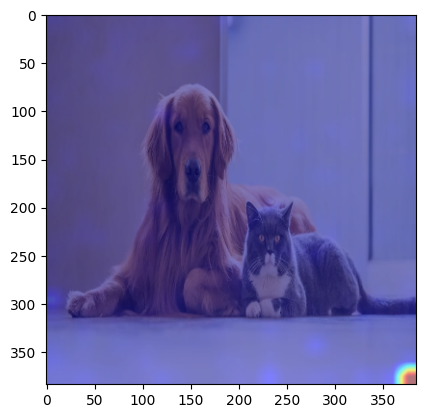

In [7]:
cam_grid = cam_tensor.reshape(24, 24)


cam = generate_gradcam(cam_grid, image)

plt.imshow(cam)
plt.show(cam)

In [8]:
attention_scores = torch.stack(outputs.attentions)
attention_scores.shape

torch.Size([24, 1, 16, 625, 625])

In [9]:
cam_tensor_arr = cam_tensor.detach().to(float).to("cpu").numpy()
cam_tensor_arr.shape

(24, 24)

In [10]:
# predicted_ids = np.argmax(output_arr, axis=-1) # [1, num_tokens]
# predicted_ids = predicted_ids.squeeze(0) # [num_tokens]
# answer = tokenizer.decode(predicted_ids[target_token_idx].tolist())
# # answer = tokenizer.decode(predicted_ids.tolist())
# answer

In [11]:
answer = tokenizer.decode(predicted_ids.tolist())
answer

NameError: name 'predicted_ids' is not defined

In [ ]:
input_ids_decoded_str = ""
for token_decoded in input_ids_decoded:
    input_ids_decoded_str += token_decoded
input_ids_decoded_str

In [ ]:
input_ids_decoded

In [ ]:
for i, token in enumerate(input_ids_decoded):
    if token == '<end_of_image>':
        print(i)
        break

In [ ]:
input_ids_decoded[target_token_idx]

In [ ]:
# [1, 576 + 1, 1024] -> adapter -> [1, 576  2048] -> "<system> You are an expert of .... <IMG><IMG>。。。"